# Comparison of bot performance for different game configurations
In this notebook we want to find out the optimal number of games for the benchmarking of the agents and explore the differences of the bot performances for different game configurations (board size and number of colors)

In [1]:
from samegamerl.evaluation.benchmark_scripts import benchmark_builtin_bots, _compute_stats
from samegamerl.evaluation.benchmark import Benchmark
from samegamerl.game.game_config import GameFactory, GameConfig
import matplotlib.pyplot as plt
import math

/Users/patrick/Library/Caches/pypoetry/virtualenvs/samegamerl-uM3J679_-py3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-10-01 08:48:07,752	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


## Find optimal number of games
First we will plot the matrics for all three built-in bots to see how quickly the cumulative metrics (i.e. how many tiles on average are left on the board) converge to a stable value. This will help us determine on how many games we should evaluate agents to get a good sense of their actual performance.

In [2]:
def compute_cumulative_stats(results: dict[str, list], num_games: int) -> dict[str, dict[str, float]]:
    """Compute performance statistics for the first num_games from benchmark results."""
    subset_results = {}
    for bot_name, performances in results.items():
        if performances and len(performances) >= num_games:
            subset_results[bot_name] = performances[:num_games]
    
    return _compute_stats(subset_results)


In [3]:
def reformat_cumulative_stats(stats: list[dict[str, dict[str, float]]]) -> dict[str, dict[str, list[float]]]:
    """
    turns a list of compute_cumulative_stats() created dicts of the form:
    [{'bot': {'metric': value } }]
    into a dict of lists of the form:
    {'metric': {'bot': [value] } }
    """
    bots = list(stats[0].keys())
    metrics = list(stats[0][bots[0]].keys())
    results = {}
    for metric in metrics:
        results[metric] = {}
        for bot in bots:
            results[metric][bot] = [s[bot][metric] for s in stats]

    return results

In [4]:
def games_per_configuration(config: GameConfig, max_games: int=10_000):
    print(f"Running benchmark with {max_games:,} games...")

    # Create benchmark with Ray CPU limit to prevent system freeze
    # Use 6 out of 10 available CPU cores, leaving 4 for system operations
    benchmark = Benchmark(
        config=config,
        num_games=max_games,
        use_ray=False,
        ray_num_cpus=6,  # Limit Ray to 6 CPU cores instead of all 10
        storage_type='database'
    )
    
    raw_results = benchmark.run_bots(benchmark.built_in_bots())
    print("finished benchmark")

    game_nums = []
    stats = []

    n = 100
    base = max_games**(1/100)
    for i in range(n):
        game_num = math.ceil(base**i)
        game_nums.append(game_num)
        
        # Compute cumulative statistics for this game count
        cumulative_stats = compute_cumulative_stats(raw_results, game_num)
        stats.append(cumulative_stats)
    
    print("finished stats computation")

    # Reverse to match original order
    stats.reverse()
    game_nums.reverse()

    return game_nums, stats

Running benchmark with 6,000 games...
Running benchmark with 6,000 games...
RandomBot: Computing 1000 missing games (total 6000)


Running RandomBot: 100%|██████████| 1000/1000 [00:00<00:00, 1442.07it/s]


LargestGroupBot: Computing 1000 missing games (total 6000)


Running LargestGroupBot: 100%|██████████| 1000/1000 [00:00<00:00, 1521.32it/s]


GreedySinglesBot: Computing 1000 missing games (total 6000)


Running GreedySinglesBot: 100%|██████████| 1000/1000 [00:02<00:00, 391.46it/s]


finished benchmark
finished stats computation
computed benchmark
computed results


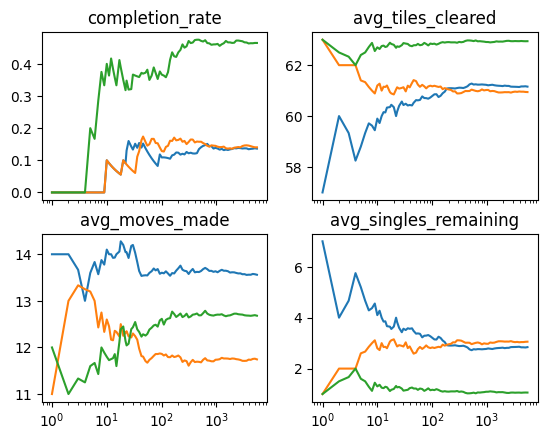

In [5]:
max_games = 6_000 

print(f"Running benchmark with {max_games:,} games...")

game_nums, stats = games_per_configuration(GameFactory.medium(), max_games)
print("computed benchmark")
results = reformat_cumulative_stats(stats)
print("computed results")

fig, axs = plt.subplots((len(results)+1)//2, 2, sharex=True)
i = 0
for metric, bots in results.items():
    for bot in bots.values():
        axs[i//2, i % 2].semilogx(game_nums, bot)
    axs[i//2, i % 2].set_title(metric)
    i += 1

We can observe the following:
1. at around 1000 games all metrics seem to converge for a 8x8 game with 3 colors in this example -> For this game configuration this is therefore a sensible size for our benchmarking set
2. tiles cleared and singles cleared are mirroring graphs, since all the current bots only stop once there are no more vaild moves left, i.e. only singles left on the board, for an agent this will not always be the case, but the two metrics being the same expresses that the agent is good in finding valid moves
3. the random bot and the largest group bot seem to perform similar on all metrics apart from moves made. This means that they arrive at the same performance, but since the largest group bot always picks the move that removes most tiles, it arrives there faster, so picking larger groups has no immediate benefit over randomly picking tiles if we want to clear the board
4. avg singles remaining (and therefore also tiles cleared) seem to be the most volatile metric, i.e. vary the most before converging. We will use this metric for now to meassure what number of games are optimal for different configuration

Running benchmark with 3,000 games...
RandomBot: Computing 2000 missing games (total 3000)


Running RandomBot: 100%|██████████| 2000/2000 [00:00<00:00, 6578.43it/s]


LargestGroupBot: Computing 2000 missing games (total 3000)


Running LargestGroupBot: 100%|██████████| 2000/2000 [00:00<00:00, 6157.11it/s]


GreedySinglesBot: Computing 2000 missing games (total 3000)


Running GreedySinglesBot: 100%|██████████| 2000/2000 [00:00<00:00, 4447.36it/s]


finished benchmark
finished stats computation
Running benchmark with 3,000 games...
RandomBot: Computing 2000 missing games (total 3000)


Running RandomBot: 100%|██████████| 2000/2000 [00:00<00:00, 5063.55it/s]


LargestGroupBot: Computing 2000 missing games (total 3000)


Running LargestGroupBot: 100%|██████████| 2000/2000 [00:00<00:00, 5377.00it/s]


GreedySinglesBot: Computing 2000 missing games (total 3000)


Running GreedySinglesBot: 100%|██████████| 2000/2000 [00:00<00:00, 3244.07it/s]


finished benchmark
finished stats computation
Running benchmark with 3,000 games...
RandomBot: Computing 2000 missing games (total 3000)


Running RandomBot: 100%|██████████| 2000/2000 [00:00<00:00, 3651.85it/s]


LargestGroupBot: Computing 2000 missing games (total 3000)


Running LargestGroupBot: 100%|██████████| 2000/2000 [00:00<00:00, 3047.01it/s]


GreedySinglesBot: Computing 2000 missing games (total 3000)


Running GreedySinglesBot: 100%|██████████| 2000/2000 [00:00<00:00, 2216.82it/s]


finished benchmark
finished stats computation
Running benchmark with 3,000 games...
RandomBot: Computing 2000 missing games (total 3000)


Running RandomBot: 100%|██████████| 2000/2000 [00:00<00:00, 2892.17it/s]


LargestGroupBot: Computing 2000 missing games (total 3000)


Running LargestGroupBot: 100%|██████████| 2000/2000 [00:00<00:00, 3032.51it/s]


GreedySinglesBot: Computing 2000 missing games (total 3000)


Running GreedySinglesBot: 100%|██████████| 2000/2000 [00:01<00:00, 1679.50it/s]


finished benchmark
finished stats computation
Running benchmark with 3,000 games...
RandomBot: Computing 2000 missing games (total 3000)


Running RandomBot: 100%|██████████| 2000/2000 [00:00<00:00, 2447.12it/s]


LargestGroupBot: Computing 2000 missing games (total 3000)


Running LargestGroupBot: 100%|██████████| 2000/2000 [00:00<00:00, 2609.25it/s]


GreedySinglesBot: Computing 2000 missing games (total 3000)


Running GreedySinglesBot: 100%|██████████| 2000/2000 [00:01<00:00, 1350.06it/s]


finished benchmark
finished stats computation


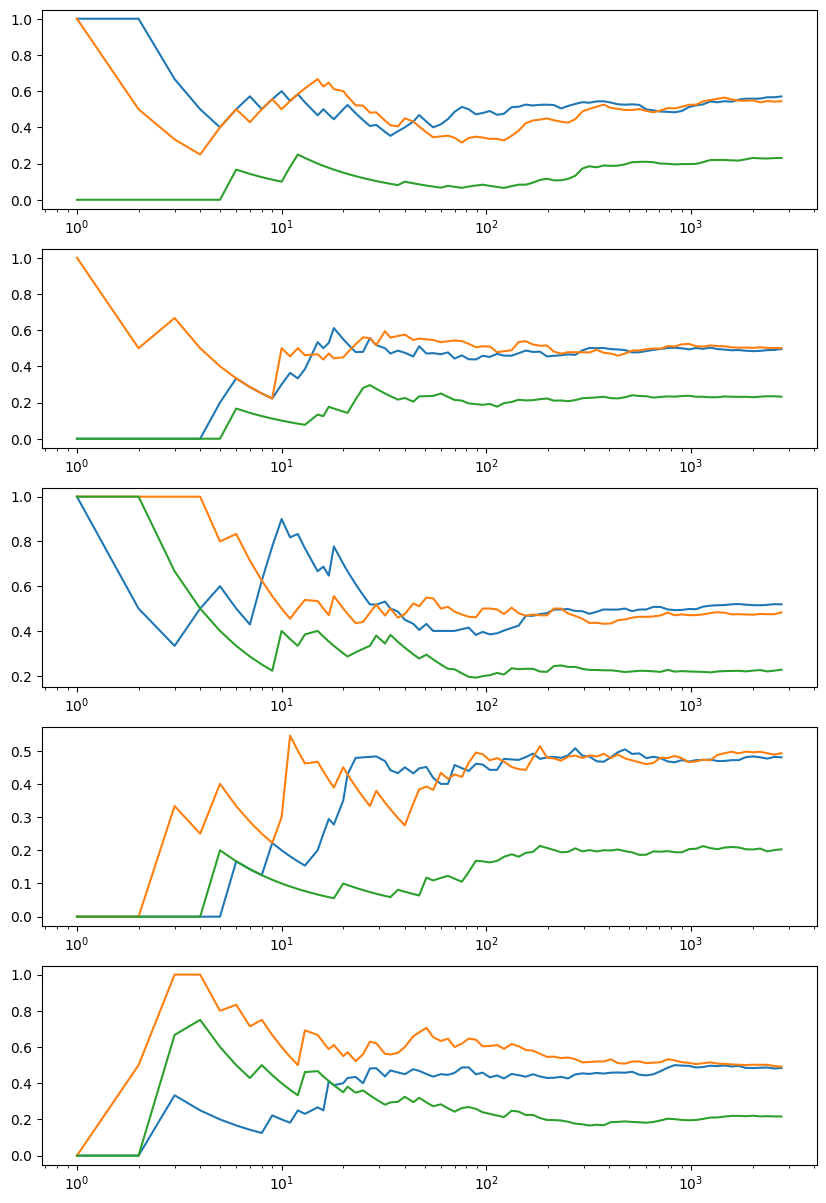

In [6]:
fig, axs = plt.subplots(5, figsize=(10, 15))

for i in range(5):
    x, stats = games_per_configuration(GameFactory.custom(8, i+3, 3), 3000)
    ys = reformat_cumulative_stats(stats)
    for bot, y in ys['avg_singles_remaining'].items():
        axs[i].semilogx(x, y, label=bot)
